In [1]:
# check API key
import os

api_key = os.environ.get("OPENAI_API_KEY")
if api_key:
    print("API key is set")
else:
    print("API key not found in environment variables")

API key is set


In [2]:
from mira.openai import OpenAIClient
from mira.sources.sympy_ode.llm_util import execute_template_model_from_sympy_odes, image_file_to_odes_str
client = OpenAIClient()

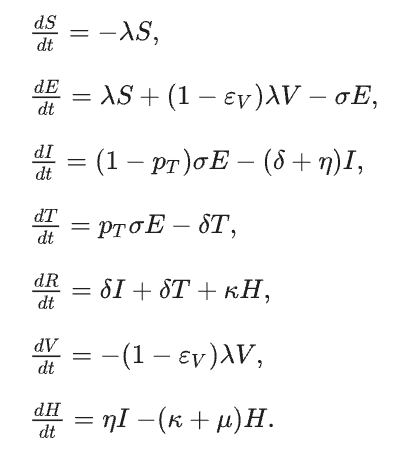

In [14]:
# Extract ODEs from image
from IPython.display import Image
image_path = 'images/odes_to_mira_SEVITHR.png'
Image(image_path)

In [4]:
#ode_str = image_file_to_odes_str('images/odes_to_mira_SEVITHR.png', client=client)
#print(ode_str)
# Note that the LLM sometimes misses to define one of the parameters. When this happens, a human-in-the-loop can quickly edit the output

In [6]:
# Cleaned version of string above, uncomment to use it
ode_str = """import sympy

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, E, I, T, R, V, H = sympy.symbols("S E I T R V H", cls=sympy.Function)

# Define the parameters
lambda_, epsilon_v, p_T, delta, eta, kappa, mu, sigma = sympy.symbols("lambda_ epsilon_v p_T delta eta kappa mu sigma")

odes = [
   sympy.Eq(S(t).diff(t), - lambda_ * S(t)),
   sympy.Eq(E(t).diff(t), lambda_ * S(t) + (1 - epsilon_v) * lambda_ * V(t) - sigma * E(t)),
   sympy.Eq(I(t).diff(t), (1 - p_T) * sigma * E(t) - (delta + eta) * I(t)),
   sympy.Eq(T(t).diff(t), p_T * sigma * E(t) - delta * T(t)),
   sympy.Eq(R(t).diff(t), delta * I(t) + delta * T(t) + kappa * H(t)),
   sympy.Eq(V(t).diff(t), - (1 - epsilon_v) * lambda_ * V(t)),
   sympy.Eq(H(t).diff(t), eta * I(t) - (kappa + mu) * H(t))
    ]"""

print(ode_str)

import sympy

# Define time variable
t = sympy.symbols("t")

# Define the time-dependent variables
S, E, I, T, R, V, H = sympy.symbols("S E I T R V H", cls=sympy.Function)

# Define the parameters
lambda_, epsilon_v, p_T, delta, eta, kappa, mu, sigma = sympy.symbols("lambda_ epsilon_v p_T delta eta kappa mu sigma")

odes = [
   sympy.Eq(S(t).diff(t), - lambda_ * S(t)),
   sympy.Eq(E(t).diff(t), lambda_ * S(t) + (1 - epsilon_v) * lambda_ * V(t) - sigma * E(t)),
   sympy.Eq(I(t).diff(t), (1 - p_T) * sigma * E(t) - (delta + eta) * I(t)),
   sympy.Eq(T(t).diff(t), p_T * sigma * E(t) - delta * T(t)),
   sympy.Eq(R(t).diff(t), delta * I(t) + delta * T(t) + kappa * H(t)),
   sympy.Eq(V(t).diff(t), - (1 - epsilon_v) * lambda_ * V(t)),
   sympy.Eq(H(t).diff(t), eta * I(t) - (kappa + mu) * H(t))
    ]


In [7]:
# Now get a template model from the extracted ODE str and send the ODE system in for attempting to ground each compartment
from mira.sources.sympy_ode.llm_util import execute_template_model_from_sympy_odes

tm = execute_template_model_from_sympy_odes(ode_str=ode_str, attempt_grounding=True, client=client)

INFO: [2025-08-26 11:54:37] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Running multi-agent validation...


INFO: [2025-08-26 11:54:52] httpx - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Raw response: ```json
{
    "has_errors": true,
    "errors": [
        "Parameter consistency: The identifier 'ido:0000511' is repeated for both the infected individuals (I) and treatment (T) which creates ambiguity in concept grounding. Each concept should have a unique identifier.",
        "Time dependency ch...


In [8]:
# Check the concepts
print('concept name\tidentifiers\tcontext')
for concept in tm.get_concepts_map().values():
    print(f'{concept.name}\t{concept.identifiers}\t{concept.context}')

concept name	identifiers	context
R	{'ido': '0000592'}	{'state': 'recovered', 'species': 'ncbitaxon:9606'}
H	{'ido': '0000511'}	{'hospitalization': 'ncit:C25179', 'species': 'ncbitaxon:9606'}
I	{'ido': '0000511'}	{'severity': 'infected', 'species': 'ncbitaxon:9606'}
S	{'ido': '0000514'}	{'severity': 'susceptible', 'species': 'ncbitaxon:9606'}
E	{'apollosv': '00000154'}	{'state': 'exposed', 'species': 'ncbitaxon:9606'}
V	{'ido': '0000514'}	{'status': 'vaccinated', 'species': 'ncbitaxon:9606'}
T	{'ido': '0000511'}	{'severity': 'infected', 'treatment': 'quarantine'}


In [9]:
from mira.modeling import Model
from mira.modeling.ode import OdeModel
om = OdeModel(Model(tm), initialized=True)
om.get_interpretable_kinetics()

Matrix([
[Derivative(H, t), =,                                                  -H*(kappa + mu) + I*eta],
[Derivative(R, t), =,                                              H*kappa + I*delta + T*delta],
[Derivative(I, t), =,                                      E*sigma*(1 - p_T) - I*(delta + eta)],
[Derivative(S, t), =,                                                               -S*lambda_],
[Derivative(E, t), =, -E*p_T*sigma - E*sigma*(1 - p_T) + S*lambda_ + V*lambda_*(1 - epsilon_v)],
[Derivative(V, t), =,                                               -V*lambda_*(1 - epsilon_v)],
[Derivative(T, t), =,                                                    E*p_T*sigma - T*delta]])

### Saving the results here: *mira/notebooks/equation extraction development/extraction error check/string mismatch check/extracted_eqs_all versions_EXCEL.xlsx*

In [16]:
import pandas as pd
from pathlib import Path

In [18]:
def save_ode_results(ode_str, input_filename):
    """
    Save ODE extraction results to Excel file.
    
    Parameters:
    -----------
    ode_str : str
        The extracted ODEs from MIRA
    input_filename : str
        The input file name (e.g., 'model_name.png')
    """

    excel_path = './equation extraction development/extraction error check/string mismatch check/extracted_eqs_all versions_EXCEL.xlsx'
    model_name = Path(input_filename).stem

    try:
        df = pd.read_excel(excel_path, engine='openpyxl')
    except FileNotFoundError:
        df = pd.DataFrame(columns=['model', 'version002'])

    if 'model' in df.columns:
        model_exists = df['model'] == model_name

        if model_exists.any():
            df.loc[model_exists, 'version002'] = ode_str
        else:
            new_row = pd.DataFrame({
                'model': [model_name],
                'version002': [ode_str]
            })
            df = pd.concat([df, new_row], ignore_index=True)
    else:
        df['model'] = model_name
        df['version002'] = ode_str

    df.to_excel(excel_path, index=False, engine='openpyxl')
    print(f"Saved equations for model '{model_name}'")

In [21]:
# only need the odes fro the comparison
start = ode_str.find('odes = [')
end = ode_str.find(']', start) + 1
ode_str_clean = ode_str[start:end]

print(ode_str_clean)

odes = [
   sympy.Eq(S(t).diff(t), - lambda_ * S(t)),
   sympy.Eq(E(t).diff(t), lambda_ * S(t) + (1 - epsilon_v) * lambda_ * V(t) - sigma * E(t)),
   sympy.Eq(I(t).diff(t), (1 - p_T) * sigma * E(t) - (delta + eta) * I(t)),
   sympy.Eq(T(t).diff(t), p_T * sigma * E(t) - delta * T(t)),
   sympy.Eq(R(t).diff(t), delta * I(t) + delta * T(t) + kappa * H(t)),
   sympy.Eq(V(t).diff(t), - (1 - epsilon_v) * lambda_ * V(t)),
   sympy.Eq(H(t).diff(t), eta * I(t) - (kappa + mu) * H(t))
    ]


In [22]:
save_ode_results(ode_str_clean, image_path)

Saved equations for model 'odes_to_mira_SEVITHR'
